In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd 'drive/MyDrive/Colab Notebooks/WRI-Hackathon/python_scripts/training'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive/MyDrive/Colab Notebooks/WRI-Hackathon/python_scripts/training'
/content/drive/MyDrive/Colab Notebooks/WRI-Hackathon/python_scripts/training


### Import libraries

In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import OneCycleLR, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import sys
# sys.path.insert(0, '../models')
# from krs_inflow_model import SimpleMLP

### Read Datasets

In [4]:
inflow_df = pd.read_csv('../dataset/reservoir_rainfall_dataset_en.csv')
inflow_df = inflow_df[inflow_df['RESERVOIR'] == 'K.R.S']
print(inflow_df.shape)
inflow_df.head()

(3274, 11)


,RESERVOIR,PRESENT_STORAGE_TMC,RES_LEVEL_FT,INFLOW_CUSECS,OUTFLOW_CUECS,YEAR,MONTH,DATE,DAY,RAINFALL,SEASON
0,K.R.S,46.42,122.59,2029.0,2000.0,2011,1,1,0,0.0226,WINTER
1,K.R.S,46.54,122.68,3084.0,1490.0,2011,1,2,1,0.0226,WINTER
2,K.R.S,46.64,122.75,2776.0,1491.0,2011,1,3,2,0.0226,WINTER
3,K.R.S,46.69,122.79,2311.0,1491.0,2011,1,4,3,0.0226,WINTER
4,K.R.S,46.70,122.80,1847.0,1491.0,2011,1,5,4,0.0226,WINTER


In [5]:
rainfall_df = pd.read_csv('../dataset/Rainfall 2010-2020/rainfall_dataset.csv')
print(rainfall_df.shape)
rainfall_df.head()

(357, 14)


,DISTRICTS,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
0,BAGALKOTE,2008,0.0,16.7,94.2,10.3,37.5,46.5,28.3,60.2,135.4,60.3,27.2,0.3
1,BAGALKOTE,2009,0.0,0.0,2.9,14.8,66.3,119.0,41.7,107.3,195.6,220.1,28.8,31.2
2,BAGALKOTE,2010,13.4,0.1,0.0,10.6,57.4,109.7,89.6,149.3,64.2,58.3,83.2,0.4
3,BAGALKOTE,2011,0.0,1.9,0.4,39.2,81.0,74.9,77.6,107.0,57.1,90.4,0.0,0.0
4,BENGALURU RURAL,2008,0.0,2.1,100.9,15.2,100.7,11.8,149.1,223.0,103.9,150.4,25.2,2.3


In [6]:
departure_df = pd.read_csv('../dataset/Rainfall 2010-2020/rainfall_departure_dataset.csv')
print(departure_df.shape)
departure_df.head()

(334, 14)


,DISTRICTS,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
0,BAGALKOTE,2008,-100.0,882.0,1677.0,-57.0,-35.0,-37.0,-63.0,-16.0,-7.0,-41.0,-2.0,-95.0
1,BAGALKOTE,2009,-100.0,-100.0,-45.0,-38.0,14.0,62.0,-45.0,50.0,35.0,116.0,4.0,380.0
2,BAGALKOTE,2010,1118.0,-94.0,-100.0,-56.0,-1.0,50.0,18.0,109.0,-56.0,-43.0,200.0,-94.0
3,BAGALKOTE,2011,-100.0,27.0,-91.0,67.0,41.0,-6.0,5.0,48.0,-58.0,-20.0,-100.0,-100.0
4,BAGALKOTE,2012,-100.0,-99.0,-100.0,36.0,-69.0,-59.0,-26.0,-6.0,-64.0,-17.0,65.0,-100.0


### Dataset Transformation

In [7]:
inflow_df = inflow_df.drop(columns=['RESERVOIR', 'PRESENT_STORAGE_TMC', 'RES_LEVEL_FT', 'OUTFLOW_CUECS', 'DATE'])
inflow_df.head()

,INFLOW_CUSECS,YEAR,MONTH,DAY,RAINFALL,SEASON
0,2029.0,2011,1,0,0.0226,WINTER
1,3084.0,2011,1,1,0.0226,WINTER
2,2776.0,2011,1,2,0.0226,WINTER
3,2311.0,2011,1,3,0.0226,WINTER
4,1847.0,2011,1,4,0.0226,WINTER


In [8]:
rainfall_df = rainfall_df.melt(id_vars=['DISTRICTS', 'YEAR'], var_name='MONTH', value_name='RAINFALL')
rainfall_df.head()

,DISTRICTS,YEAR,MONTH,RAINFALL
0,BAGALKOTE,2008,JAN,0.0
1,BAGALKOTE,2009,JAN,0.0
2,BAGALKOTE,2010,JAN,13.4
3,BAGALKOTE,2011,JAN,0.0
4,BENGALURU RURAL,2008,JAN,0.0


In [9]:
departure_df = departure_df.melt(id_vars=['DISTRICTS', 'YEAR'], var_name='MONTH', value_name='DEPARTURE')
departure_df.head()

,DISTRICTS,YEAR,MONTH,DEPARTURE
0,BAGALKOTE,2008,JAN,-100.0
1,BAGALKOTE,2009,JAN,-100.0
2,BAGALKOTE,2010,JAN,1118.0
3,BAGALKOTE,2011,JAN,-100.0
4,BAGALKOTE,2012,JAN,-100.0


In [10]:
rainfall_df = rainfall_df[rainfall_df['DISTRICTS'] == 'KODAGU']
departure_df = departure_df[departure_df['DISTRICTS'] == 'KODAGU']

rainfall_df.shape, departure_df.shape

((156, 4), (156, 4))

In [11]:
month_df = pd.DataFrame.from_dict({1: 'JAN', 2: 'FEB', 3: 'MAR', 4: 'APR', 5: 'MAY', 6: 'JUN',
                                   7: 'JUL', 8: 'AUG', 9: 'SEP', 10: 'OCT', 11: 'NOV', 12: 'DEC'}, orient='index').reset_index()
month_df.columns = ['index', 'MONTH']
month_df.head()

,index,MONTH
0,1,JAN
1,2,FEB
2,3,MAR
3,4,APR
4,5,MAY


In [ ]:
rainfall_departure_df = pd.merge(left=rainfall_df, right=departure_df, how='outer', on=['MONTH', 'YEAR', 'DISTRICTS']).merge(month_df, on='MONTH')
rainfall_departure_df.drop(columns=['DISTRICTS', 'MONTH'], inplace=True)
rainfall_departure_df.rename(columns={'index': 'MONTH'}, inplace=True)
rainfall_departure_df.head()

,YEAR,RAINFALL,DEPARTURE,MONTH
0,2008,0.0,-100.0,1
1,2009,0.0,-100.0,1
2,2010,12.4,188.0,1
3,2011,0.7,-80.0,1
4,2012,0.5,-86.0,1


### Dataset and DataLoader

In [ ]:
month_le = LabelEncoder().fit(inflow_df['MONTH'].unique())
day_le = LabelEncoder().fit(inflow_df['DAY'].unique())
season_le = LabelEncoder().fit(inflow_df['SEASON'].unique())

In [ ]:
train_inflow_df = inflow_df[inflow_df['YEAR'] < 2020]
val_inflow_df = inflow_df[inflow_df['YEAR'] == 2020]

train_inflow_df.shape, val_inflow_df.shape

((2944, 6), (330, 6))

In [ ]:
class InflowDataset(Dataset):
    def __init__(self, df):
        self.df = df
    
    def __getitem__(self, index):
        inflow, year, month, day, rainfall, season = self.df.iloc[index].values
        monthly_rainfall = rainfall_departure_df[(rainfall_departure_df['YEAR'] == year) & (rainfall_departure_df['MONTH'] == month)]['RAINFALL'].values
        prev_rainfall_departure_df = rainfall_departure_df[(rainfall_departure_df['YEAR'] < year) & (rainfall_departure_df['MONTH'] == month)].sort_values('YEAR', ascending=False).head(3)
        prev_avg_rainfall = prev_rainfall_departure_df['RAINFALL'].values.mean()
        prev_avg_departure = prev_rainfall_departure_df['DEPARTURE'].values.mean()
        
        month_transformed = month_le.transform([month])
        day_transformed = day_le.transform([day])
        season_transformed = season_le.transform([season])

        return (torch.tensor(month_transformed[0]), \
                torch.tensor(day_transformed[0]), \
                torch.tensor(season_transformed[0]), \
                torch.FloatTensor([prev_avg_rainfall, prev_avg_departure])), (torch.FloatTensor([inflow]), torch.FloatTensor(monthly_rainfall))
    
    def __len__(self):
        return self.df.shape[0]

In [ ]:
train_ds = InflowDataset(train_inflow_df)
val_ds = InflowDataset(val_inflow_df)
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
val_dl = DataLoader(val_ds, batch_size=32, num_workers=2)

### Model

In [ ]:
class SimpleMLP(nn.Module):
    def __init__(self, nmonth, nday, nseason):
        super().__init__()
        self.month_emb = nn.Embedding(num_embeddings=nmonth, embedding_dim=128)
        self.day_emb = nn.Embedding(num_embeddings=nday, embedding_dim=128)
        self.season_emb = nn.Embedding(num_embeddings=nseason, embedding_dim=128)
        self.prev_data_layer = nn.Sequential(
            nn.Linear(in_features=2, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=128),
            nn.ReLU()
        )
        self.hidden_layer = nn.Sequential(
            nn.Linear(in_features=128*4, out_features=768),
            nn.LeakyReLU(),
            nn.Linear(in_features=768, out_features=256),
            nn.LeakyReLU(),
        )
        self.rainfall_layer = nn.Sequential(
            nn.BatchNorm1d(num_features=256),
            nn.Linear(in_features=256, out_features=128),
            nn.LeakyReLU(),
            nn.Linear(in_features=128, out_features=64),
            nn.LeakyReLU(),
            nn.Linear(in_features=64, out_features=1),
            nn.ReLU()
        )
        
        self.inflow_layer = nn.Sequential(
            nn.BatchNorm1d(num_features=256),
            nn.Linear(in_features=256, out_features=64),
            nn.LeakyReLU(),
            nn.Linear(in_features=64, out_features=1),
            nn.ReLU()
        )
    
    def forward(self, x_month, x_day, x_season, x_prev_data):
        month_out = self.day_emb(x_month)
        day_out = self.day_emb(x_day)
        season_out = self.season_emb(x_season)
        prev_data_out = self.prev_data_layer(x_prev_data)

        x = torch.cat([month_out, day_out, season_out, prev_data_out], axis=1)
        hidden_out = self.hidden_layer(x)
        rainfall_out = self.rainfall_layer(hidden_out)
        inflow_out = self.inflow_layer(hidden_out)

        return rainfall_out, inflow_out
    
    def weight_init(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Embedding):
                nn.init.xavier_uniform_(m.weight)

### Training

In [ ]:
def train(model, epochs, lr):
    opt = Adam(model.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(opt, patience=12, min_lr=1e-8)
    criterion = nn.MSELoss()

    mean_inflow = train_inflow_df['INFLOW_CUSECS'].mean()
    mean_rainfall = rainfall_departure_df['RAINFALL'].mean()
    inflow_loss_weight = int((mean_inflow + mean_rainfall) / mean_inflow)
    rainfall_loss_weight = int((mean_inflow + mean_rainfall) / mean_rainfall)
    for epoch in range(epochs):
        train_loss = 0
        val_loss = 0

        model.train()
        for xb, yb in train_dl:
            x_month = xb[0].cuda()
            x_day = xb[1].cuda()
            x_season = xb[2].cuda()
            x_prev_data = xb[3].cuda()
            y_inflow = yb[0].cuda()
            y_rainfall = yb[1].cuda()

            y_hat = model(x_month, x_day, x_season, x_prev_data)
            y_hat_rainfall = y_hat[0]
            y_hat_inflow = y_hat[1]
            loss = rainfall_loss_weight * criterion(y_hat_rainfall, y_rainfall) + inflow_loss_weight * criterion(y_hat_inflow, y_inflow)

            opt.zero_grad()
            loss.backward()
            opt.step()

            train_loss += loss.item()
        
        model.eval()
        with torch.no_grad():
            for xb, yb in val_dl:
                x_month = xb[0].cuda()
                x_day = xb[1].cuda()
                x_season = xb[2].cuda()
                x_prev_data = xb[3].cuda()
                y_inflow = yb[0].cuda()
                y_rainfall = yb[1].cuda()

                y_hat = model(x_month, x_day, x_season, x_prev_data)
                y_hat_rainfall = y_hat[0]
                y_hat_inflow = y_hat[1]
                loss = rainfall_loss_weight * criterion(y_hat_rainfall, y_rainfall) + inflow_loss_weight * criterion(y_hat_inflow, y_inflow)

                val_loss += loss.item()
                
        scheduler.step(train_loss)

        if scheduler._last_lr[0] <= 1e-07:
            break
        print(f'Epoch - {epoch+1} | LR - {scheduler._last_lr[0]} | Train Loss - {round(train_loss / len(train_dl), 2)} | Val Loss - {round(val_loss / len(val_dl), 2)}')

In [ ]:
model = SimpleMLP(len(month_le.classes_), len(day_le.classes_), len(season_le.classes_)).cuda()
model.weight_init()

In [ ]:
train(model, epochs=1000, lr=1e-02)

Epoch - 1 | LR - 0.01 | Train Loss - 50516044.34 | Val Loss - 16059849.95
Epoch - 2 | LR - 0.01 | Train Loss - 31467201.36 | Val Loss - 18003842.29
Epoch - 3 | LR - 0.01 | Train Loss - 28860440.66 | Val Loss - 22146510.2
Epoch - 4 | LR - 0.01 | Train Loss - 27998972.89 | Val Loss - 14766944.01
Epoch - 5 | LR - 0.01 | Train Loss - 26999519.92 | Val Loss - 20805895.69
Epoch - 6 | LR - 0.01 | Train Loss - 26634618.92 | Val Loss - 15859350.21
Epoch - 7 | LR - 0.01 | Train Loss - 26528214.97 | Val Loss - 15814654.08
Epoch - 8 | LR - 0.01 | Train Loss - 26328879.27 | Val Loss - 15274198.24
Epoch - 9 | LR - 0.01 | Train Loss - 25951413.12 | Val Loss - 14707346.33
Epoch - 10 | LR - 0.01 | Train Loss - 24854785.53 | Val Loss - 15990653.19
Epoch - 11 | LR - 0.01 | Train Loss - 25087401.29 | Val Loss - 18539954.84
Epoch - 12 | LR - 0.01 | Train Loss - 24600831.73 | Val Loss - 17682962.15
Epoch - 13 | LR - 0.01 | Train Loss - 23440832.34 | Val Loss - 20896003.53
Epoch - 14 | LR - 0.01 | Train Loss

### Prediction on Validation Dataset

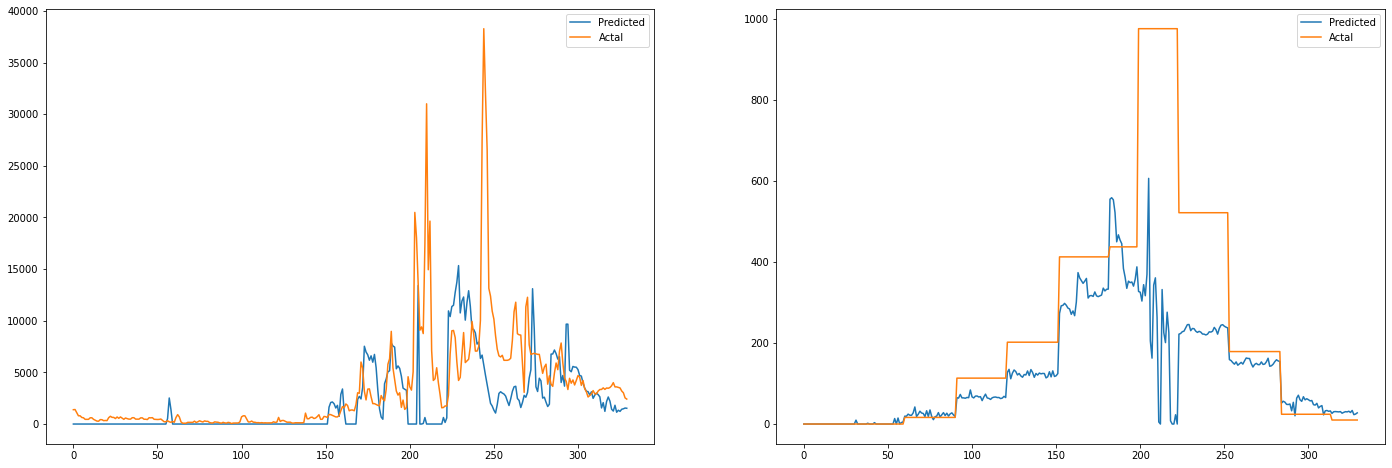

In [ ]:
y_actual_rainfall, y_pred_rainfall = [], []
y_actual_inflow, y_pred_inflow = [], []
model.eval()
with torch.no_grad():
    for xb, yb in val_dl:
        x_month = xb[0].cuda()
        x_day = xb[1].cuda()
        x_season = xb[2].cuda()
        x_prev_data = xb[3].cuda()
        y_inflow = yb[0]
        y_rainfall = yb[1]

        y_hat = model(x_month, x_day, x_season, x_prev_data)
        y_hat_rainfall = y_hat[0]
        y_hat_inflow = y_hat[1]

        y_actual_rainfall += y_rainfall.data.tolist()
        y_actual_inflow += y_inflow.data.tolist()
        y_pred_rainfall += y_hat_rainfall.cpu().data.tolist()
        y_pred_inflow += y_hat_inflow.cpu().data.tolist()

y_actual_rainfall = np.array(y_actual_rainfall).flatten()
y_actual_inflow = np.array(y_actual_inflow).flatten()
y_pred_rainfall = np.array(y_pred_rainfall).flatten()
y_pred_inflow = np.array(y_pred_inflow).flatten()

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,8))
ax1.plot(y_pred_inflow, label='Predicted')
ax1.plot(y_actual_inflow, label='Actal')
ax1.legend()
ax2.plot(y_pred_rainfall, label='Predicted')
ax2.plot(y_actual_rainfall, label='Actal')
ax2.legend()
plt.show()

### Prediction on entire Dataset

In [ ]:
def pred(df):
    pred_ds = InflowDataset(df.copy())
    pred_dl = DataLoader(pred_ds, batch_size=len(pred_ds))

    model.eval()
    with torch.no_grad():
        for x, y in pred_dl:
            x_month = x[0].cuda()
            x_day = x[1].cuda()
            x_season = x[2].cuda()
            x_prev_data = x[3].cuda()
            y_inflow = yb[0]
            y_rainfall = yb[1]

            y_hat = model(x_month, x_day, x_season, x_prev_data)
            y_hat_rainfall = y_hat[0]
            y_hat_inflow = y_hat[1]

    return y_hat_inflow.data.cpu().view(-1).tolist(), y_hat_rainfall.data.cpu().view(-1).tolist()

In [ ]:
model_test_df = inflow_df.sort_values(by=['YEAR', 'DAY']).copy()
model_test_df['Predicted_Inflow'], model_test_df['Predicted_Rainfall'] = pred(model_test_df)
model_test_df[:10]

,INFLOW_CUSECS,YEAR,MONTH,DAY,RAINFALL,SEASON,Predicted_Inflow,Predicted_Rainfall
0,2029.0,2011,1,0,0.0226,WINTER,3414.151123,0.0
1,3084.0,2011,1,1,0.0226,WINTER,3009.394043,0.0
2,2776.0,2011,1,2,0.0226,WINTER,2588.894531,0.0
3,2311.0,2011,1,3,0.0226,WINTER,2296.633301,0.0
4,1847.0,2011,1,4,0.0226,WINTER,1870.192993,0.0
5,2156.0,2011,1,5,0.0226,WINTER,1436.816772,0.0
6,1847.0,2011,1,6,0.0226,WINTER,1553.884033,0.0
7,2002.0,2011,1,7,0.0226,WINTER,1713.947510,0.0
8,1537.0,2011,1,8,0.0226,WINTER,1434.052856,0.0
9,1382.0,2011,1,9,0.0226,WINTER,1570.541626,0.0


In [ ]:
avg_daily_pred_inflow = model_test_df.groupby('DAY')['Predicted_Inflow'].mean().values
avg_daily_actual_inflow = model_test_df.groupby('DAY')['INFLOW_CUSECS'].mean().values
avg_daily_pred_rainfall = model_test_df.groupby('DAY')['Predicted_Rainfall'].mean().values
avg_daily_actual_rainfall = model_test_df.groupby('DAY')['RAINFALL'].mean().values

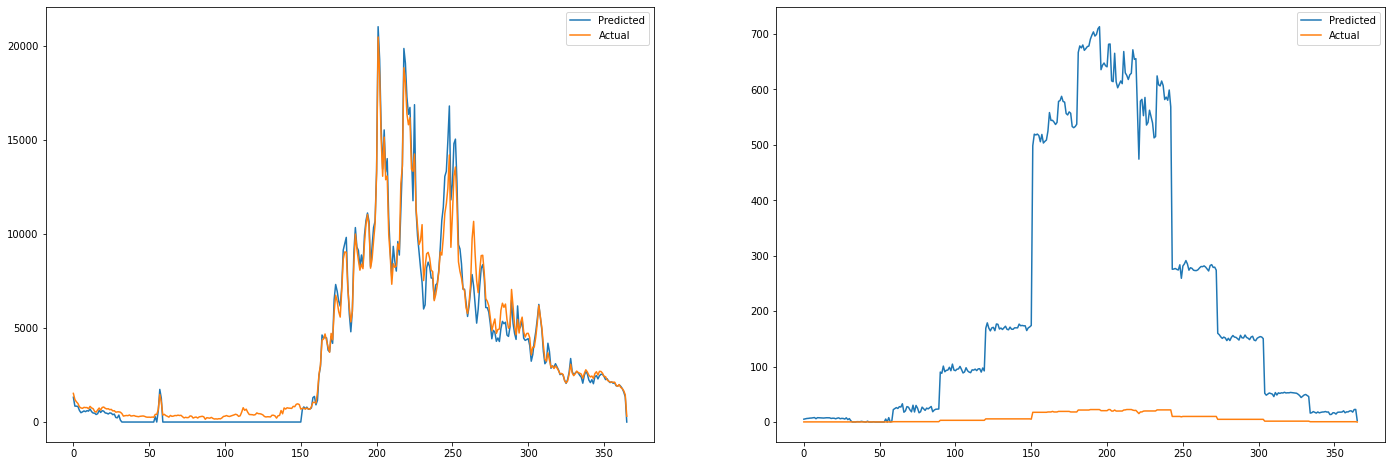

In [ ]:
# plt.figure()
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(24, 8))
ax1.plot(avg_daily_pred_inflow, label='Predicted')
ax1.plot(avg_daily_actual_inflow, label='Actual')
ax1.legend()
ax2.plot(avg_daily_pred_rainfall, label='Predicted')
ax2.plot(avg_daily_actual_rainfall, label='Actual')
ax2.legend()
plt.show()

In [ ]:
rainfall_departure_with_pred_df = pd.merge(rainfall_departure_df, model_test_df.groupby(['MONTH', 'YEAR'])['Predicted_Rainfall'].mean().reset_index(), on=['YEAR', 'MONTH'])

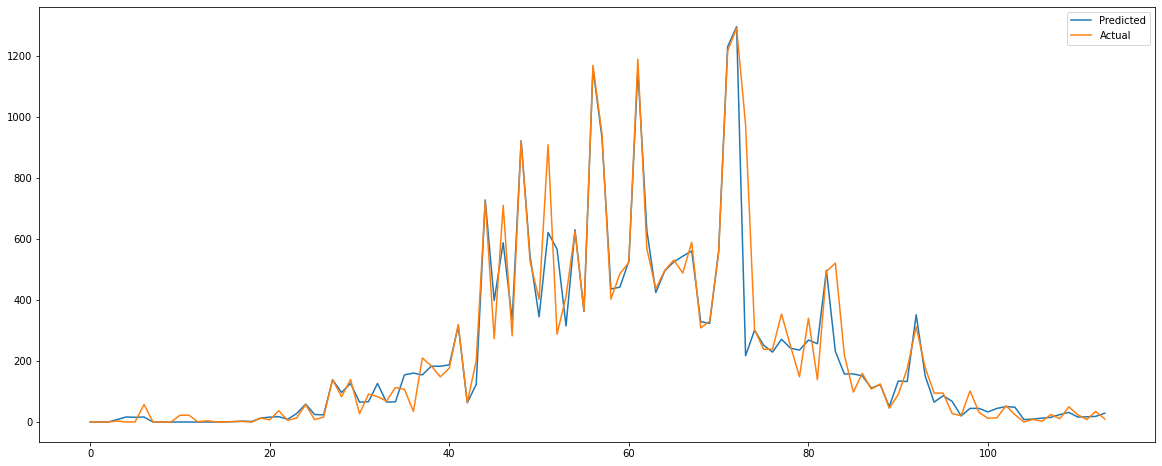

In [ ]:
plt.figure(figsize=(20, 8))
plt.plot(rainfall_departure_with_pred_df['Predicted_Rainfall'], label='Predicted')
plt.plot(rainfall_departure_with_pred_df['RAINFALL'], label='Actual')
plt.legend()
plt.show()

In [ ]:
model_test_df['Predicted_Rainfall'].describe()

count    3274.000000
mean      222.508560
std       276.902660
min         0.000000
25%        18.892738
50%       122.940445
75%       326.149124
max      1325.609497
Name: Predicted_Rainfall, dtype: float64

In [ ]:
rainfall_df['RAINFALL'].describe()

count     156.000000
mean      220.685897
std       287.744814
min         0.000000
25%        13.800000
50%       103.800000
75%       314.500000
max      1318.100000
Name: RAINFALL, dtype: float64

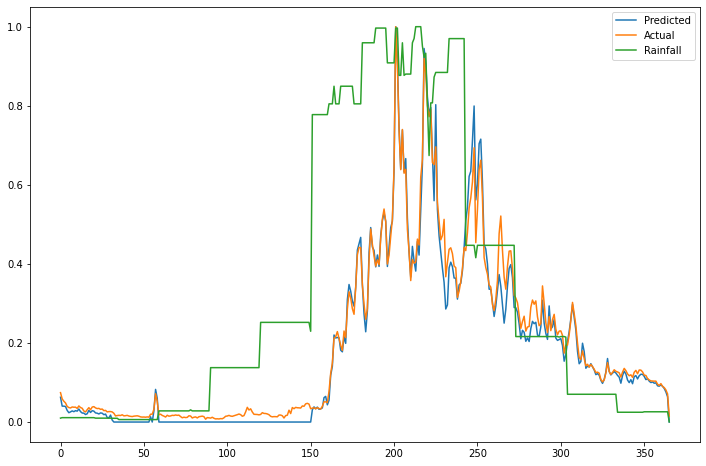

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(avg_daily_pred_inflow / avg_daily_pred_inflow.max(), label='Predicted')
plt.plot(avg_daily_actual_inflow / avg_daily_actual_inflow.max(), label='Actual')
plt.plot(avg_daily_actual_rainfall / avg_daily_actual_rainfall.max(), label='Rainfall')

plt.legend()
plt.show()

In [ ]:
model_test_df['YEAR-MONTH-DAY'] = model_test_df['YEAR'].astype(str) + '-' + model_test_df['MONTH'].astype(str) + '-' + model_test_df['DAY'].astype(str)
model_test_df.set_index('YEAR-MONTH-DAY', inplace=True)
model_test_df.head()

,INFLOW_CUSECS,YEAR,MONTH,DAY,RAINFALL,SEASON,Predicted_Inflow,Predicted_Rainfall
YEAR-MONTH-DAY,,,,,,,,
2011-1-0,2029.0,2011,1,0,0.0226,WINTER,3414.151123,0.0
2011-1-1,3084.0,2011,1,1,0.0226,WINTER,3009.394043,0.0
2011-1-2,2776.0,2011,1,2,0.0226,WINTER,2588.894531,0.0
2011-1-3,2311.0,2011,1,3,0.0226,WINTER,2296.633301,0.0
2011-1-4,1847.0,2011,1,4,0.0226,WINTER,1870.192993,0.0


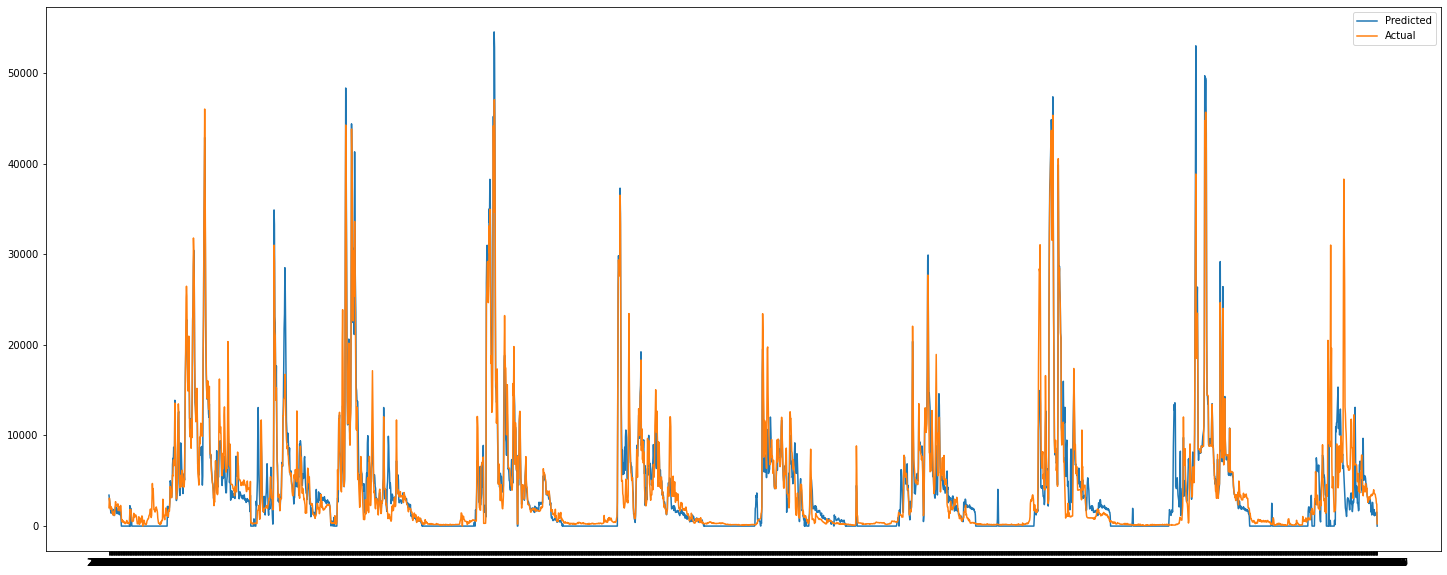

In [ ]:
plt.figure(figsize=(25, 10))
plt.plot(model_test_df['Predicted_Inflow'], label='Predicted')
plt.plot(model_test_df['INFLOW_CUSECS'], label='Actual')
plt.legend()
plt.show()

In [ ]:
train_data_with_pred = model_test_df[model_test_df['YEAR'] < 2020]
val_data_with_pred = model_test_df[model_test_df['YEAR'] == 2020]
train_data_with_pred.shape, val_data_with_pred.shape

((2944, 8), (330, 8))

In [ ]:
train_rainfall_departure_with_pred = rainfall_departure_with_pred_df[rainfall_departure_with_pred_df['YEAR'] < 2020]
val_rainfall_departure_with_pred = rainfall_departure_with_pred_df[rainfall_departure_with_pred_df['YEAR'] == 2020]
train_rainfall_departure_with_pred.shape, val_rainfall_departure_with_pred.shape

((102, 5), (12, 5))

In [ ]:
((train_data_with_pred['INFLOW_CUSECS'] - train_data_with_pred['Predicted_Inflow']) ** 2).mean() ** .5 + ((train_rainfall_departure_with_pred['RAINFALL'] - train_rainfall_departure_with_pred['Predicted_Rainfall']) ** 2).mean() ** .5      

2029.1172077538656

In [ ]:
((val_data_with_pred['INFLOW_CUSECS'] - val_data_with_pred['Predicted_Inflow']) ** 2).mean() ** .5 + ((val_rainfall_departure_with_pred['RAINFALL'] - val_rainfall_departure_with_pred['Predicted_Rainfall']) ** 2).mean() ** .5      

5138.336260968419

In [ ]:
torch.save(model.state_dict(), 'inflow_rainfall_multihead_model.pth')